In [2]:
import numpy as np
import pandas as pd

from evaluation import prepare_data, evaluate_diversity

### Load data

In [3]:
x = np.load('./data/func.npz')['fc']
df = pd.read_csv('./data/covariates.csv', index_col=0)

print(x.shape, df.shape)
df.head()

(297, 4950) (297, 4)


,age,sex,site,group
0,16.77,M,PITT,ASD
1,24.45,M,PITT,ASD
2,19.09,M,PITT,ASD
3,13.37,M,PITT,ASD
4,17.78,M,PITT,ASD


### Target variable

In [4]:
y = df.group.replace({'ASD': 1, 'TD': 0}).to_numpy().astype(int)

# and remove it from covariates
df.drop('group', axis=1, inplace=True)

y.shape

(297,)

### Matching and stratification

In [5]:
df_match, x, y = prepare_data(x, y, df, site_col='site', cat=['sex'], 
                              n_strata=10, caliper=0.2, dec=None) # No deconfounding used

print(df_match.shape, x.shape, y.shape)
df_match.head()

(290, 4) (290, 4950) (290,)


,group,ps,pair,strata
sample_idx,,,,
0,1,0.575733,0,4
1,1,0.602902,1,7
2,1,0.583830,2,5
3,1,0.564287,3,3
4,1,0.579236,4,5


### Predictive model

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Classifier - No param tunning here
clf = Pipeline([
            ('ss', StandardScaler()),
            ('clf', LogisticRegression(C=1, penalty='l2', random_state=0))]
        )

### Evaluation

In [7]:
# Params chosen for fast execution
df_strata, coef, score = evaluate_diversity(clf, x, y, df_match, n_train_strata=7, n_splits=2, n_jobs=6, verbose=True)

Within-distribution elapsed time: 11.94s
Out-of-distribution elapsed time: 12.48s


### Gather results

In [8]:
# Within-distribution predition performance (ROC-AUC)
div_wd = df_strata.train.intra_ps
auc_wd = score['default']['cv']['auc']
wd = pd.DataFrame(np.c_[div_wd, auc_wd], columns=['Div', 'ROC-AUC'])

# Out-of-distribution predition performance (ROC-AUC)
div_ood = np.concatenate(df_strata.test.inter_ps_strata)
auc_ood = score['default']['test'].loc['strata', 'auc']
ood = pd.DataFrame(np.c_[div_ood, auc_ood], columns=['Div', 'ROC-AUC'])


scores = pd.concat([wd, ood], keys=['WD', 'OOD'], names=['perf'])
scores.reset_index(0, inplace=True)
scores.head()

,perf,Div,ROC-AUC
0,WD,0.017987,0.752941
1,WD,0.021315,0.751538
2,WD,0.024976,0.718603
3,WD,0.029608,0.629437
4,WD,0.022882,0.790142


### Plot results

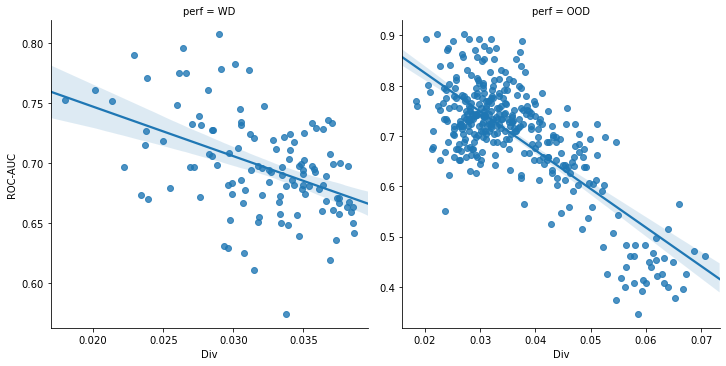

In [9]:
import seaborn as sns

sns.lmplot(x='Div', y='ROC-AUC', data=scores, col='perf', sharex=False, sharey=False, truncate=False)